In [36]:
import galois
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from IPython.display import clear_output, HTML
from matplotlib import animation
from ipywidgets import Image
from ipycanvas import Canvas, hold_canvas

GF = galois.GF(2)

class LightsOut:

    def __init__(self, grid):
        self.grid = list(map(tuple, (np.array(grid) - np.min(grid, axis=0)).tolist()))
        self.grid.sort(key=lambda i: i[0])
        self.n = len(self.grid)
        self.point_number_map = dict(zip(self.grid, range(self.n)))

        self.k1, self.k2 = np.max(self.grid, axis=0) + 1
        self.cm = ListedColormap(['#E76F51', '#36BA98'])
        self.alphas = np.zeros((self.k1, self.k2))
        for i in self.grid:
            self.alphas[i] = 1

        self.stamp_effect = np.array([(1, 0), (0, 1), (0, 0), (-1, 0), (0, -1)])
        
        self.action_matrix = GF(np.array([self.act_vec(point) for point in self.grid], dtype=int)) 
    
    def point_number(self, point):
        '''Returns the name/number of a particular point/location on the grid'''
        return self.point_number_map[tuple(point)]

    def number_point(self, number):
        '''Opposite of point_number'''
        assert number<self.n
        return self.grid[number]
    
    def stamp(self, point):
        '''Return co-ordinates of affected regions when stamped'''
        return [i for i in (np.array(point) + self.stamp_effect) if tuple(i) in self.grid]
    
    def act_vec(self, point):
        '''Creates the action vector when "stamped" on a particular point'''
        result = np.zeros(self.n)
        for affected in self.stamp(point):
            result[self.point_number(affected)] = 1
        
        return result
    
    def state_to_plane(self, state_vec):
        '''Constructs displayable plane from a state configuration'''
        plane = -1 * np.ones((self.k1, self.k2))
        for i in range(self.n):
            if state_vec[i]:
                plane[self.number_point(i)] = 1
            else:
                plane[self.number_point(i)] = 0
        return plane
    
    def displane(self, plane, ax=None, label=True):

        if ax is None:
            ax = plt.axes()

        plt.axis('off')
        ax.set_xticks([])
        ax.set_yticks([])

        cm = ListedColormap(['#E76F51', '#36BA98'])

        frame = [ax.imshow(plane, alpha=(env.alphas).astype(float), vmin=-1, vmax=2, cmap=cm)]

        if label:
            for (i, j) in env.grid:
                frame.append(ax.text(j, i, env.point_number((i, j)), ha="center", va="center"))
        
        return ax, frame
    
    def play(self, state = None):

        if state is None:
            state = GF(np.ones(self.n).astype(int))

        plane = self.state_to_plane(state)
        self.displane(plane)
        plt.show()

        while any(state):
            next_move = int(input('Enter state to stamp on: '))
            if next_move == -1:
                print('Giving up...')
                break

            state += self.action_matrix[:, next_move]
            
            plane = self.state_to_plane(state)
            self.displane(plane)
            
            clear_output()
            plt.show()
        else:
            print('Solved!')
    
    def solve(self, state = None):

        if state is None:
            state = GF(np.ones(self.n).astype(int))
        
        A = np.c_[self.action_matrix, state]
        self.A_rref = A.row_reduce()

        reqs = np.arange(self.n)[self.A_rref[:, -1]==1]
        
        moves = []
        for i in reqs:
            for j in range(self.n):
                a = self.A_rref[:, j]
                if a[i] == 1 and not any(np.concatenate((a[:i], a[i+1:]))):
                    # print(a, j)
                    moves.append(j)
                    break
        # print(self.A_rref[:, -1])
        return np.array(moves)
    
    def illustrate_solution(self, state=None, label=False):
        if state is None:
            state = GF(np.ones(self.n).astype(int))

        sol = self.solve(state)

        artists = []
        fig, ax = plt.subplots()

        plane = self.state_to_plane(state)
        ax, frame = self.displane(plane, ax=ax, label=label)
        artists.append(frame)

        for i in sol:

            state += self.action_matrix[:, i]
            plane = self.state_to_plane(state)
            ax, frame = self.displane(plane, ax=ax, label=label)
            artists.append(frame)

        plt.close()
        interval = 200 if label else 50
        anim = animation.ArtistAnimation(fig, artists, interval=interval, repeat=False, blit=False);
        return HTML(anim.to_jshtml())

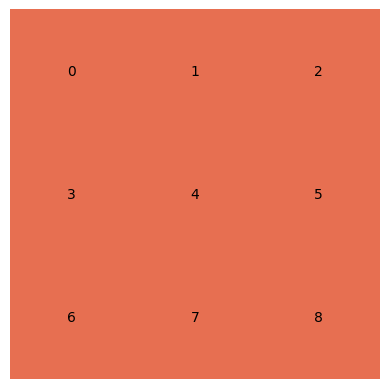

Solved!


In [28]:
env = LightsOut([(i, j) for i in range(3) for j in range(3)])
env.play()

In [41]:
env = LightsOut([(i, j) for i in range(5) for j in range(5)])
print(env.solve())

[ 1  2  4  6  7  8 12 13 14 15 16 18 19 20 21]


In [44]:
env.illustrate_solution(label=True)

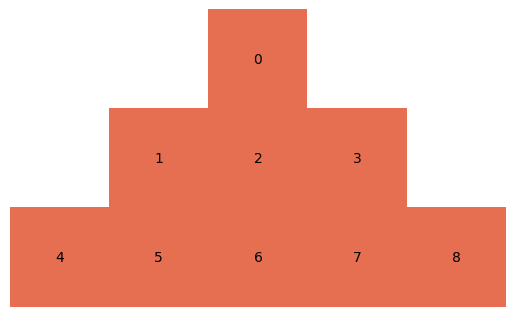

Solved!


In [45]:
env = LightsOut([(0, 2), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4)])
env.play()

In [46]:
env.illustrate_solution(label=True)

In [23]:
width, height = 800, 500

canvas = Canvas(width=width, height=height, sync_image_data=True)
canvas.fill_style = "#DA7297"
canvas.fill_rect(int(0.95*width), 0, width/20, height)
canvas.fill_style = "#667BC6"

drawing = False
marker_size = 25

def myround(x, base=marker_size):
    return base * round((x-base//2)/base)

def on_mouse_down(x, y):
    global drawing
    drawing = True

    if x >= int(0.95*width):
        canvas.clear_rect(0, 0, int(0.95*width), height)

def on_mouse_move(x, y):
    global drawing
    if not drawing:
        return

    with hold_canvas():
        canvas.fill_rect(myround(x), myround(y), marker_size)

def on_mouse_up(x, y):
    global drawing
    drawing = False


canvas.on_mouse_down(on_mouse_down)
canvas.on_mouse_move(on_mouse_move)
canvas.on_mouse_up(on_mouse_up)

canvas

Canvas(sync_image_data=True, width=800)

In [40]:
grid = (canvas.get_image_data().sum(axis=2)[:,:int(0.95*width)][::marker_size, ::marker_size] > 0).astype(int)
grid = [(i, j) for i in range(grid.shape[0]) for j in range(grid.shape[1]) if grid[(i, j)]]

env = LightsOut(grid)
env.illustrate_solution()